# PDE Problem Data Generation

In [1]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN

# CP
from utils_uqmd.utils_uq_cp import CP

# Ensure reproducibility
import random, numpy as np, torch
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

Using device: cpu
Using device: cpu


In [ ]:
# Data Noise
data_noise = 0.05

# Define PDE
domain=((0.0, 1.0), (0.0, 1.0))
true_solution=lambda xy: torch.sin(math.pi * xy[..., 0:1]) * torch.sin(math.pi * xy[..., 1:2])
pde = Poisson2D(domain, true_solution)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(500, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(200, data_noise)

# Define CP

In [3]:
colloc_pt_num = 100

# Deterministic + CP

## Deterministic

ep     1 | L=9.09e+01 | data=1.47e-01 | pde=9.07e+01  ic=0.00e+00  bc=2.53e-02 | lr=3.00e-03


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


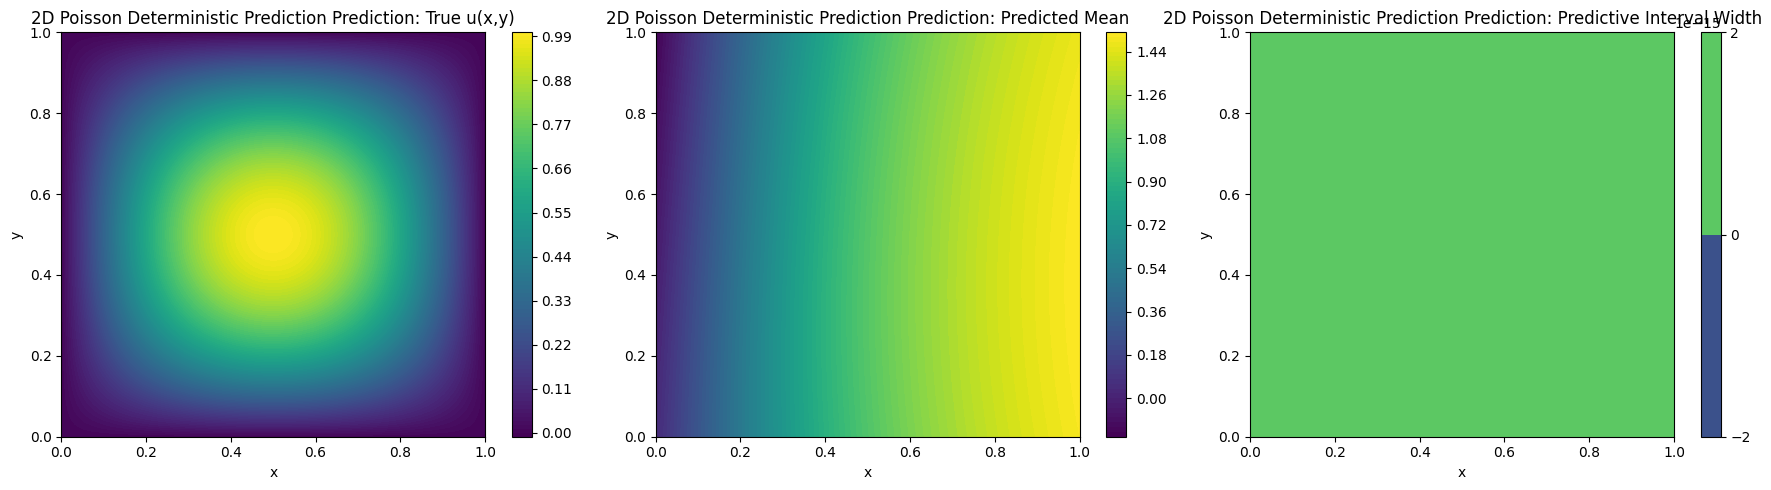

In [5]:
# --------------------------------------------
# 1. Build base model
# --------------------------------------------
MLP_model = MLPPINN(
    pde_class=pde, 
    input_dim=2, 
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    act_cls=nn.Tanh
)

# --------------------------------------------
# 2. Training
# --------------------------------------------
mlp_loss_dict = MLP_model.fit(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train,
    Y_train=Y_train,
    λ_pde=1.0,
    λ_bc=5.0,
    λ_ic=0.0,
    epochs=10,
    lr=3e-3,
)

# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
pred_set = MLP_model.predict(
    alpha=0.05, 
    X_test=grid_test
) 

plot_predictions_2D(
    grid_test,
    pred_set,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)


##  Deterministic + CP

ep     1 | L=8.91e+01 | data=4.49e-01 | pde=8.85e+01  ic=0.00e+00  bc=3.77e-02 | lr=3.00e-03


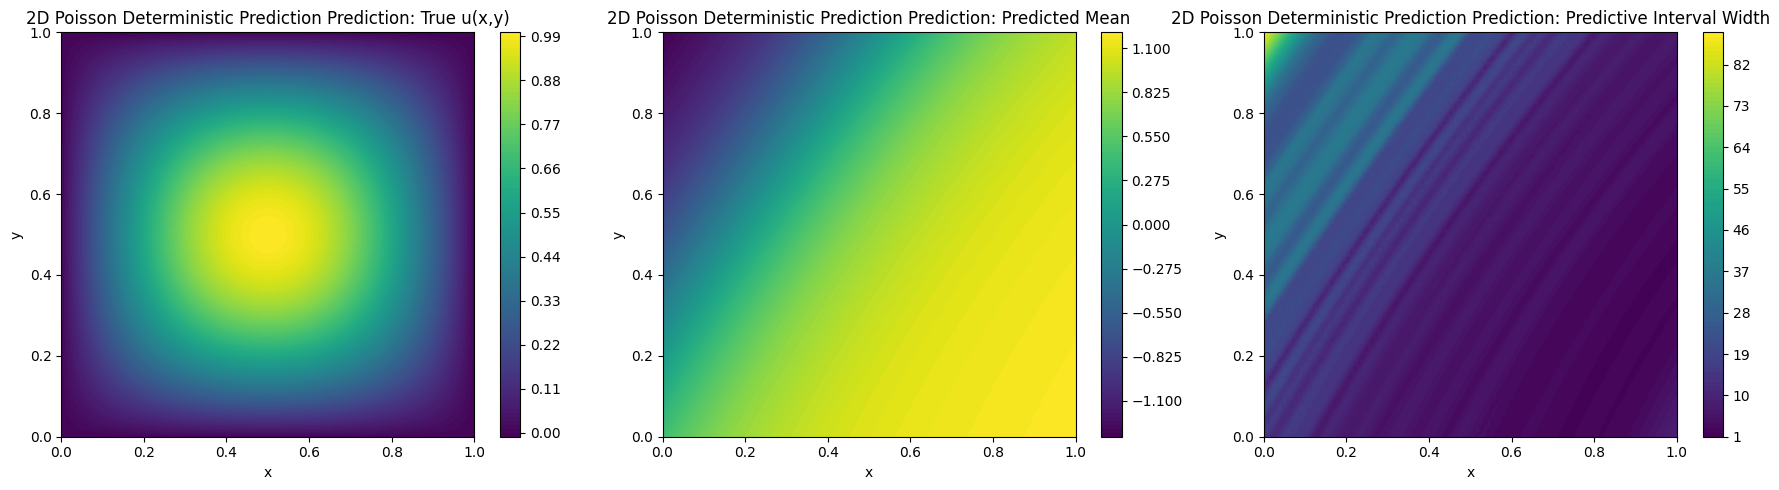

In [6]:
# --------------------------------------------
# 1. Build base model
# --------------------------------------------
MLP_model = MLPPINN(
    pde_class=pde, 
    input_dim=2, 
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    act_cls=nn.Tanh
)

# --------------------------------------------
# 2. Training
# --------------------------------------------
mlp_loss_dict =MLP_model.fit(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train,
    Y_train=Y_train,
    λ_pde=1.0,
    λ_bc=5.0,
    λ_ic=0.0,
    epochs=10,
    lr=3e-3,
)

# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
pred_set = MLP_model.predict(
    alpha=0.05, 
    X_test=grid_test
) 

# plot_predictions_2D(
#     grid_test,
#     pred_set,
#     true_solution=pde.true_solution,
#     title="2D Poisson Deterministic Prediction Prediction"
# )


# CP
cp_deterministic = CP(model=MLP_model)
cp_predset = cp_deterministic.predict(
    alpha=0.05, 
    X_test=grid_test, 
    X_train=X_train, Y_train=Y_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, 
    heuristic_u="latent", k=20)

plot_predictions_2D(
    grid_test,
    cp_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)


In [7]:
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = cp_test_uncertainties(cp_deterministic, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, Y_train, heuristic_u="feature", k=10)

rslt

100%|██████████| 8/8 [00:00<00:00, 340.07it/s]


,alpha,coverage,sharpness
0,0.111111,0.94,2.321649
1,0.222222,0.80,1.903613
2,0.333333,0.66,1.639510
3,0.444444,0.50,1.288169
4,0.555556,0.40,0.954014
5,0.666667,0.23,0.670576
6,0.777778,0.13,0.437526
7,0.888889,0.06,0.212990


## Metrics

### Coverage Plot

### Sharpness

# VI Models + CP

## VI Baseline

In [8]:
# --------------------------------------------
# 2. Build base model
# --------------------------------------------
vi_model = VIBPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    mu_std = 0.01, rho = -5, prior_std=1.0, 
    init_data_noise=1.0, learn_data_noise=False, act_func=nn.Tanh()
)

# --------------------------------------------
# 3. Training
# --------------------------------------------
vi_loss_dict = vi_model.fit(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train, Y_train=Y_train,
    λ_pde=5.0, λ_ic=1.0, λ_bc=10.0, λ_elbo=1.0, λ_data=1.0,
    epochs=300, lr=3e-3,
    scheduler_cls=StepLR, scheduler_kwargs={'step_size': 5000, 'gamma': 0.5},
    stop_schedule=40000
)


ep     0 | L=5.86e+04 | elbo=1.65e+02 | pde=1.17e+04  ic=0.00e+00  bc=1.22e-06 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     1 | L=6.64e+04 | elbo=1.66e+02 | pde=1.32e+04  ic=0.00e+00  bc=3.53e-05 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     3 | L=5.00e+04 | elbo=1.60e+02 | pde=9.97e+03  ic=0.00e+00  bc=1.58e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     6 | L=4.17e+04 | elbo=1.59e+02 | pde=8.31e+03  ic=0.00e+00  bc=5.77e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     9 | L=3.62e+04 | elbo=1.56e+02 | pde=7.20e+03  ic=0.00e+00  bc=3.19e-03 | lr=3.00e-03 | learned noise_std=1.000e+00
ep    12 | L=7.73e+04 | elbo=1.44e+02 | pde=1.54e+04  ic=0.00e+00  bc=1.60e-02 | lr=3.00e-03 | learned noise_std=1.000e+00
ep    15 | L=3.74e+04 | elbo=1.25e+02 | pde=7.46e+03  ic=0.00e+00  bc=1.13e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep    18 | L=3.77e+04 | elbo=1.26e+02 | pde=7.52e+03  ic=0.00e+00  bc=2.94e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep    21 | L=3.5

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


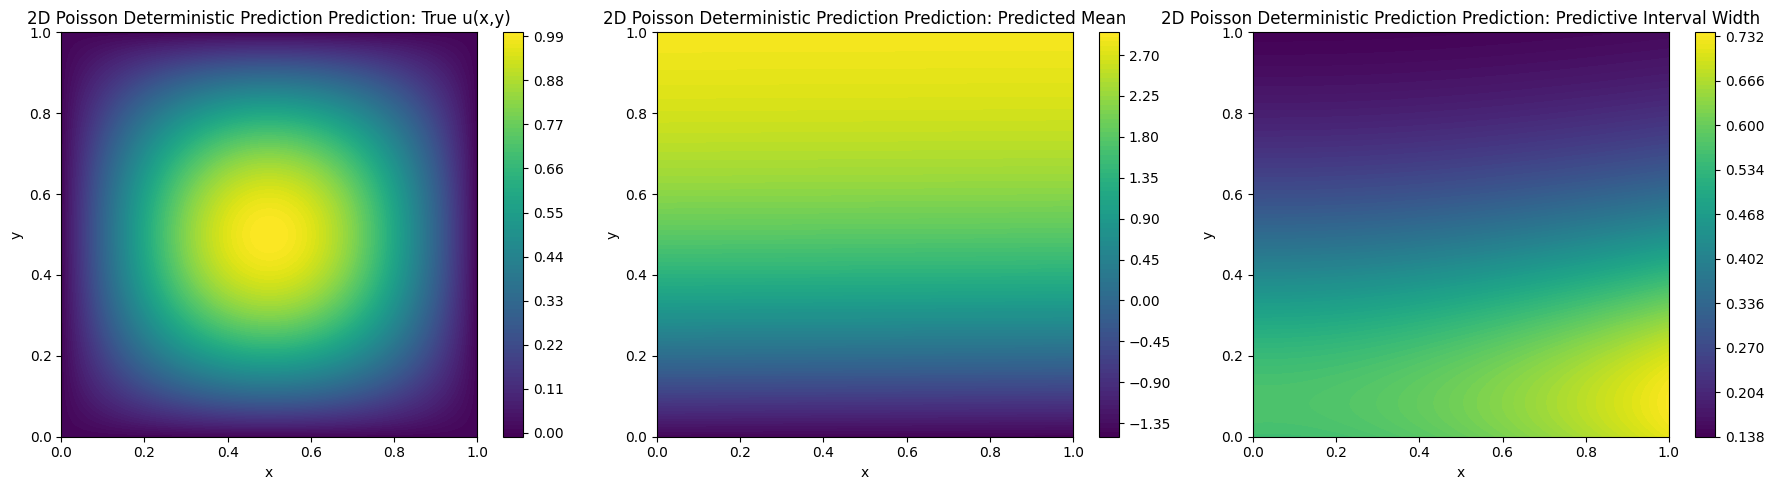

In [9]:
# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
vi_uncal_predset = vi_model.predict(
    alpha=0.05, 
    X_test=grid_test, 
    n_samples=100,) 

plot_predictions_2D(
    grid_test,
    vi_uncal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

## VI + CP

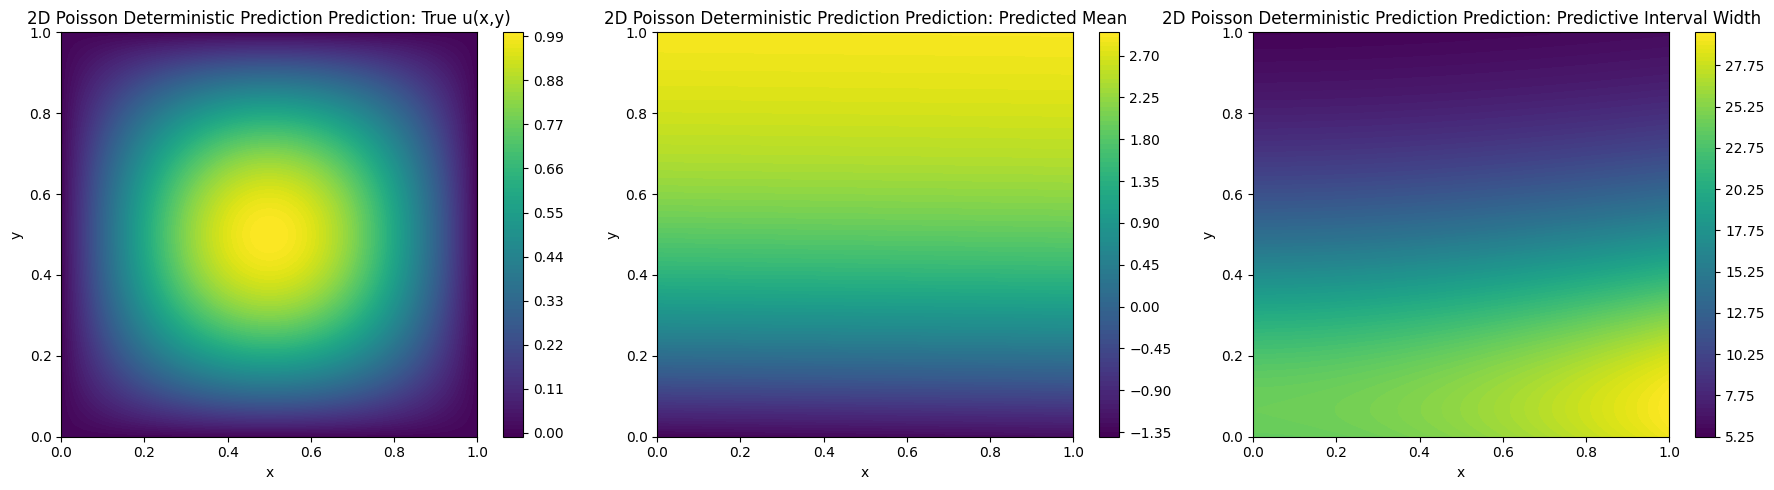

In [10]:
# CP
cp_vi = CP(model=vi_model)
vi_cal_predset = cp_vi.predict(
    alpha=0.05,
    X_test=grid_test,
    X_train=X_train, Y_train=Y_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, 
    heuristic_u="raw_std")

plot_predictions_2D(
    grid_test,
    vi_cal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

# Metrics

In [11]:
# --------------------------------------------
# 1. Uncalibrated model (Baseline)
# --------------------------------------------

from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_uncal_rslt = vi_test_uncertainties(
    vi_model, 
    alphas, 
    X_test, Y_test)

vi_uncal_rslt

100%|██████████| 8/8 [00:00<00:00, 11.94it/s]


,alpha,coverage,sharpness
0,0.111111,0.08,0.327678
1,0.222222,0.06,0.249625
2,0.333333,0.04,0.198435
3,0.444444,0.04,0.153488
4,0.555556,0.03,0.117389
5,0.666667,0.03,0.089221
6,0.777778,0.03,0.062214
7,0.888889,0.00,0.032874


In [13]:
# --------------------------------------------
# 2. Calibrated model (Baseline)
# --------------------------------------------

from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties

def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_cal_rslt = cp_test_uncertainties(cp_vi, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, Y_train, heuristic_u="raw_std")

vi_cal_rslt

  0%|          | 0/8 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 8/8 [01:13<00:00,  9.15s/it]


,alpha,coverage,sharpness
0,0.111111,0.92,14.271161
1,0.222222,0.86,10.303222
2,0.333333,0.72,6.922678
3,0.444444,0.61,4.553431
4,0.555556,0.52,2.363368
5,0.666667,0.38,1.435992
6,0.777778,0.22,0.869553
7,0.888889,0.11,0.471357


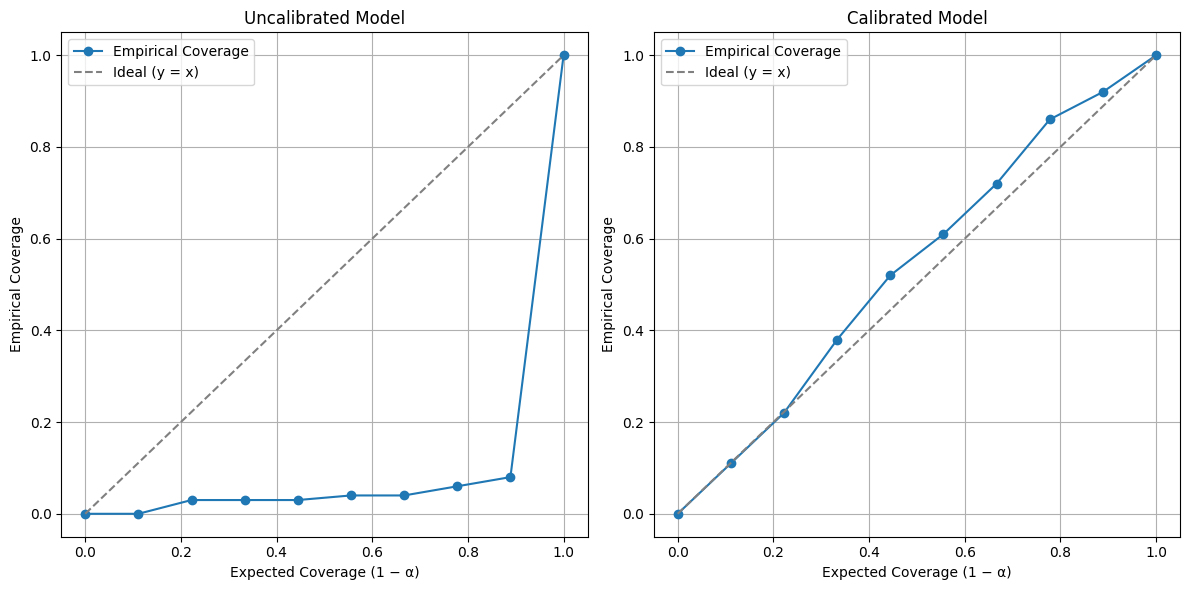

In [15]:
# --------------------------------------------
# 3. Coverage Plot
# --------------------------------------------

from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
plot_dual_expected_vs_empirical(df_uncal=vi_uncal_rslt, df_cal=vi_cal_rslt)

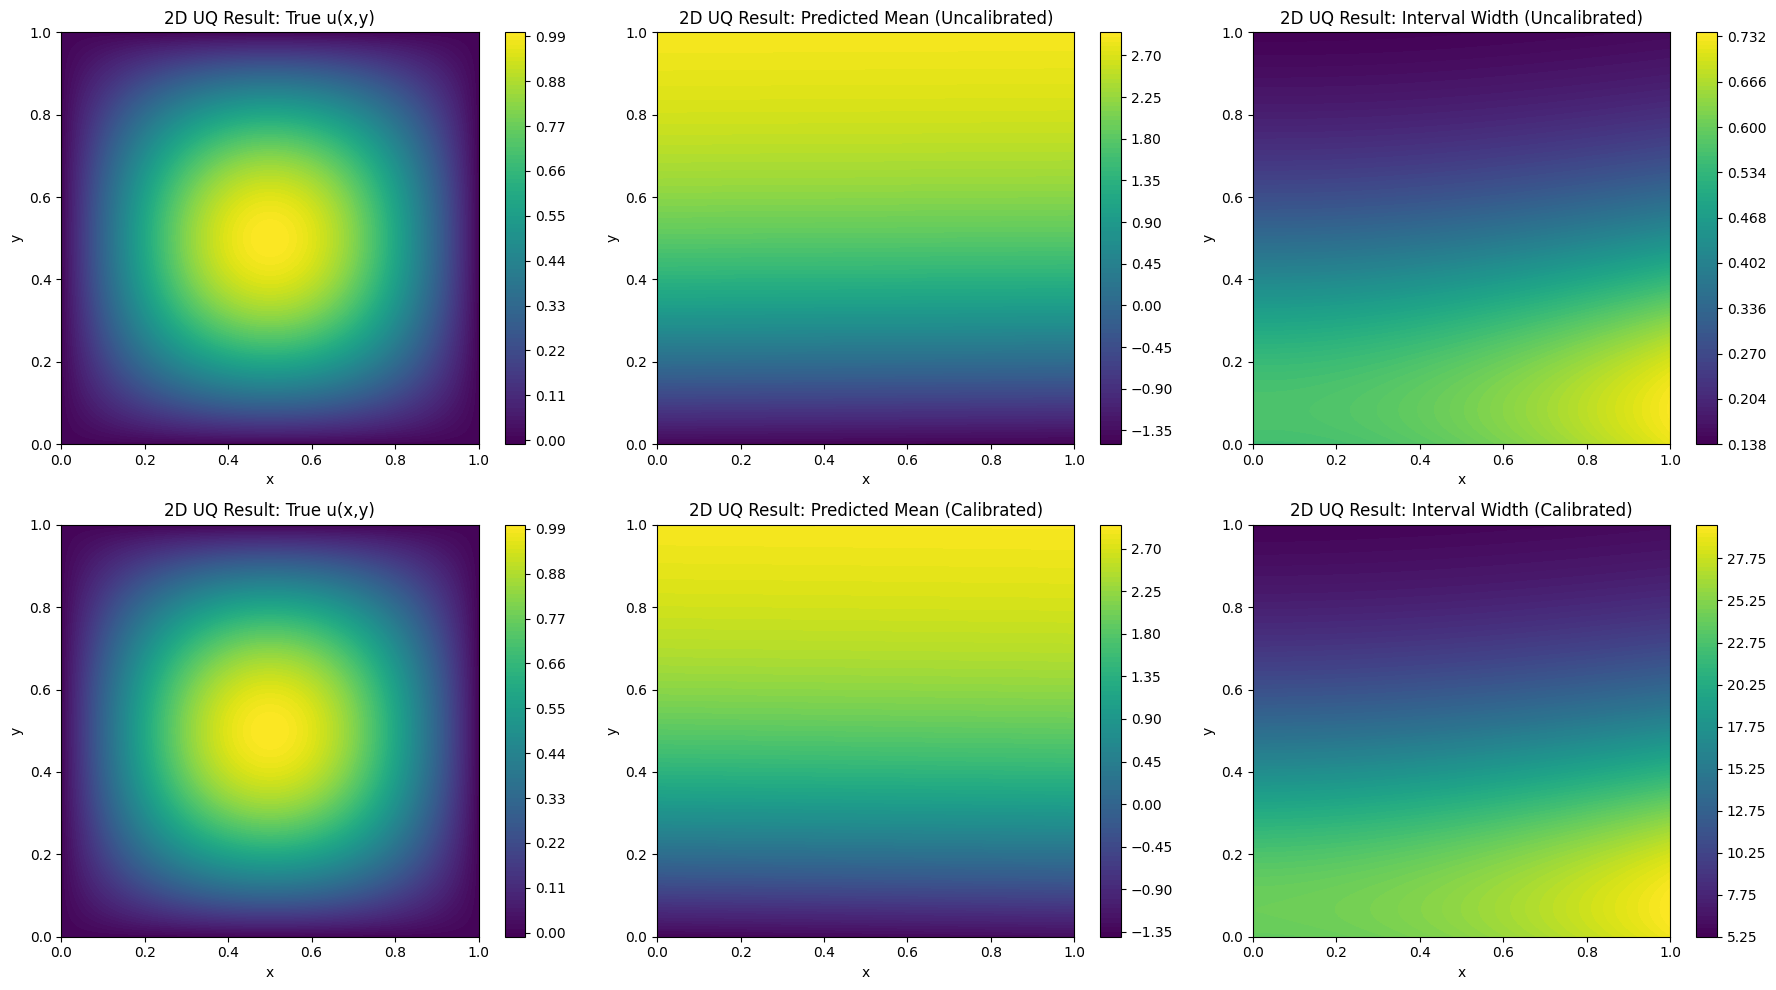

In [16]:
from utils_tools.utils_result_viz import plot_predictions_2D_compare

plot_predictions_2D_compare(grid_test, vi_uncal_predset, vi_cal_predset, true_solution, title="2D UQ Result")

# Dropout Model + CP

## Dropout Baseline

In [ ]:
# --------------------------------------------
# 2. Build base model
# --------------------------------------------
do_pinn = DropoutPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    p_drop=0.1
)

# --------------------------------------------
# 3. Training
# --------------------------------------------
vi_loss_dict = do_pinn.fit(
    coloc_pt_num=colloc_pt_num,
    X_train=X_train, Y_train=Y_train,
    λ_pde=5.0, λ_ic=1.0, λ_bc=5.0, λ_data=1.0,
    epochs=100, lr=3e-3,
    scheduler_cls=StepLR, scheduler_kwargs={'step_size': 5000, 'gamma': 0.5},
    stop_schedule=40000
)


ep     1 | L=5.30e+02 | data=3.04e-01 | pde=1.06e+02  ic=0.00e+00  bc=4.10e-03 | lr=3.00e-03


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


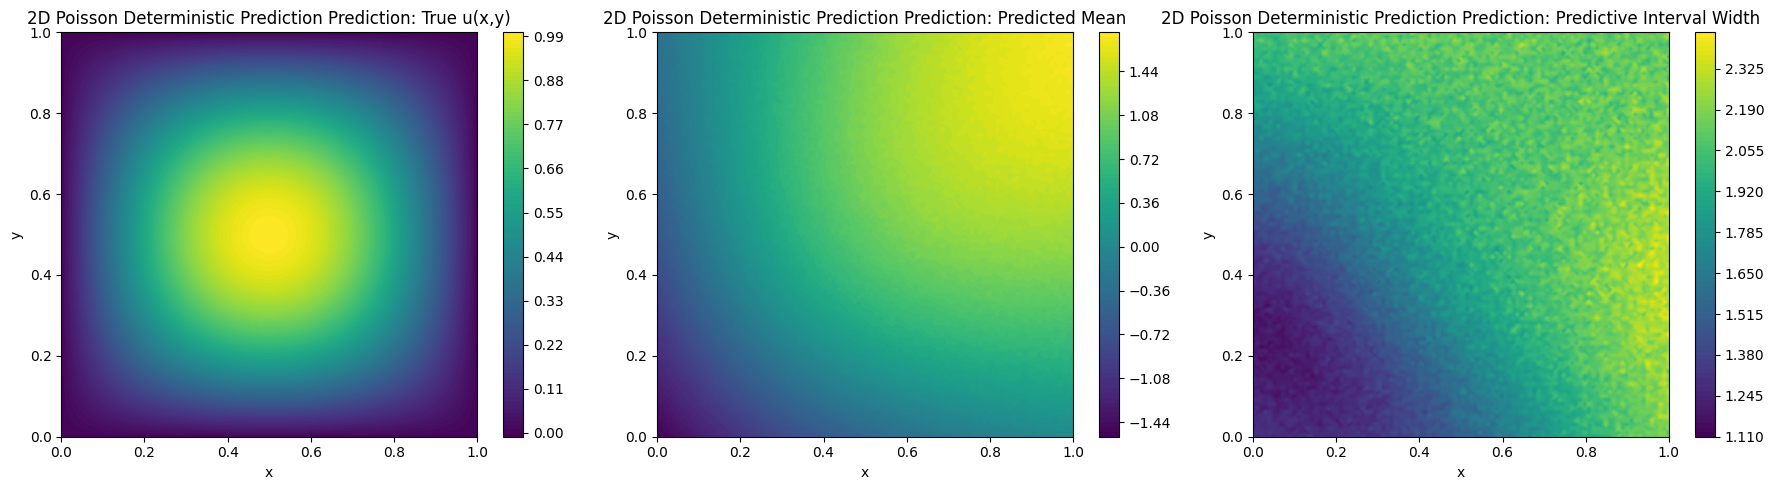

In [ ]:
# --------------------------------------------
# 3. Prediction & Visulization
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)

# Retrun a deterministic Prediction
cp_uncal_predset = do_pinn.predict(
    alpha=0.05, 
    X_test=grid_test,
    n_samples = 1000,

) 

plot_predictions_2D(
    grid_test,
    cp_uncal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

## Dropout + CP

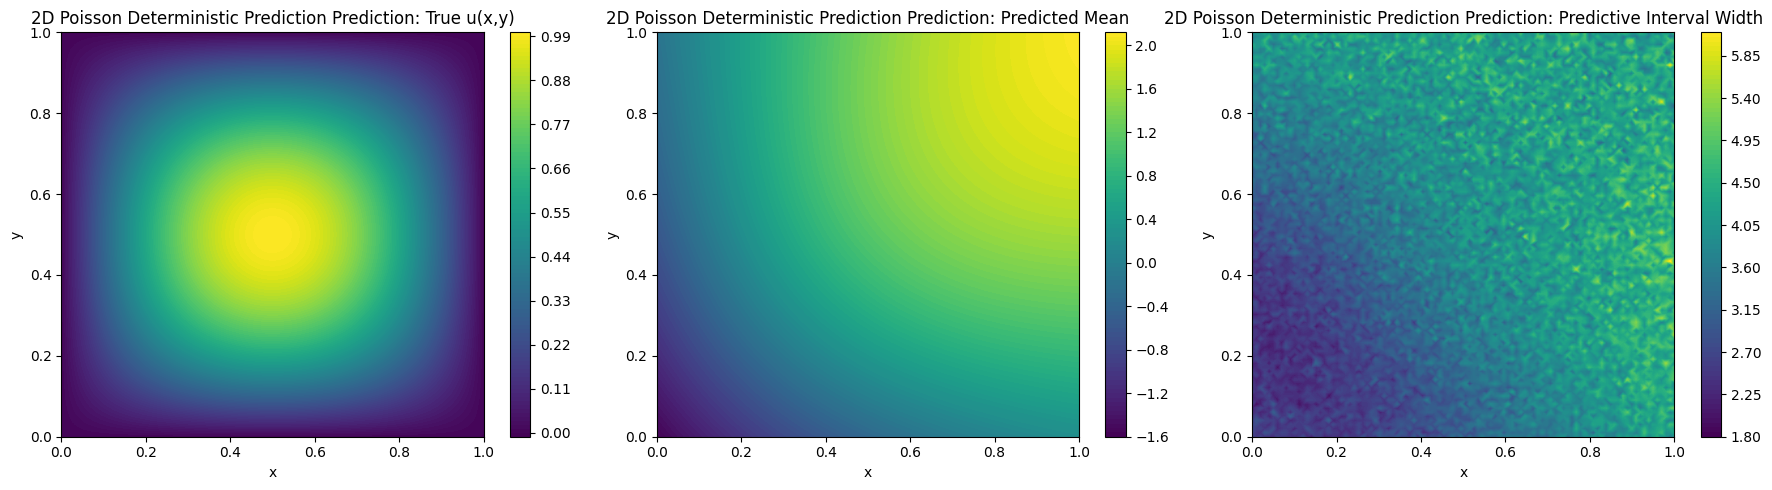

In [ ]:
# CP
cp_do = CP(model=do_pinn)
cp_cal_predset = cp_do.predict(
    alpha=0.05,
    X_test=grid_test,
    X_train=X_train, Y_train=Y_train, 
    X_cal=X_calibration, Y_cal=Y_calibration, 
    heuristic_u="raw_std")

plot_predictions_2D(
    grid_test,
    cp_cal_predset,
    true_solution=pde.true_solution,
    title="2D Poisson Deterministic Prediction Prediction"
)

# Metrics

In [ ]:
# --------------------------------------------
# 1. Uncalibrated model (Baseline)
# --------------------------------------------

from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_uncal_rslt = do_test_uncertainties(
    do_pinn, 
    alphas, 
    X_test, Y_test,
    n_samples=1000
)

vi_uncal_rslt

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


,alpha,coverage,sharpness
0,0.111111,0.64,1.491943
1,0.222222,0.52,1.151596
2,0.333333,0.44,0.910180
3,0.444444,0.38,0.715627
4,0.555556,0.26,0.553600
5,0.666667,0.16,0.407523
6,0.777778,0.14,0.264728
7,0.888889,0.08,0.131614


In [ ]:
# --------------------------------------------
# 2. Calibrated model (Baseline)
# --------------------------------------------

from utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties

def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

vi_cal_rslt = cp_test_uncertainties(cp_do, alphas, X_test, Y_test, X_calibration, Y_calibration, X_train, Y_train, heuristic_u="raw_std")

vi_cal_rslt

  0%|          | 0/8 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


,alpha,coverage,sharpness
0,0.111111,0.91,3.171472
1,0.222222,0.85,2.482479
2,0.333333,0.67,1.869713
3,0.444444,0.55,1.451064
4,0.555556,0.47,1.063832
5,0.666667,0.35,0.722385
6,0.777778,0.31,0.537040
7,0.888889,0.14,0.213438


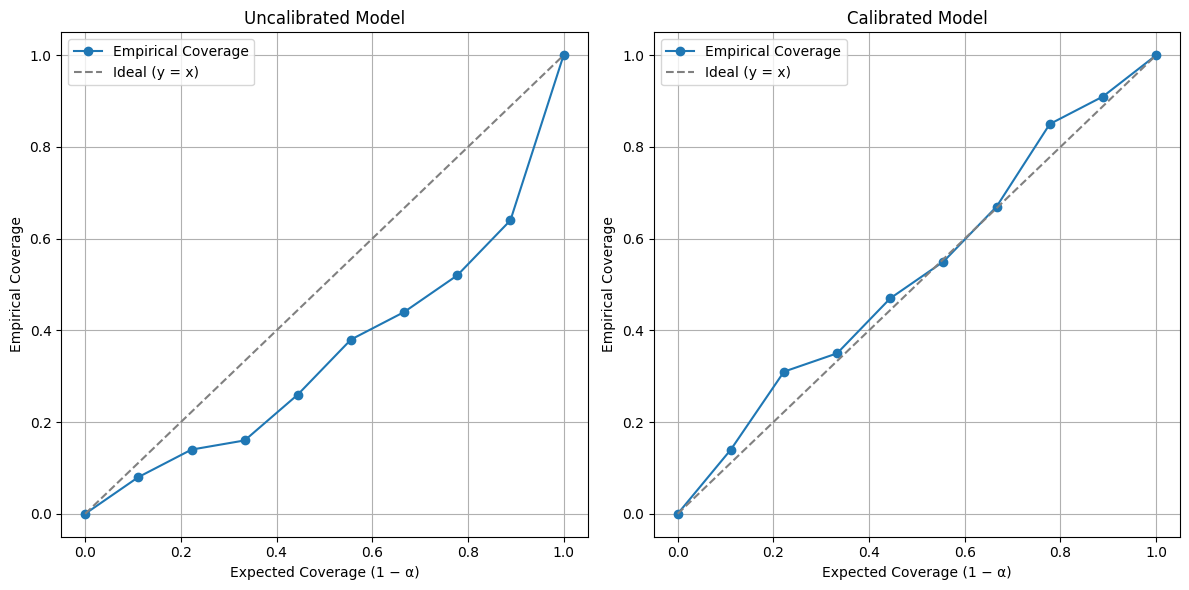

In [ ]:
# --------------------------------------------
# 3. Coverage Plot
# --------------------------------------------

from utils_tools.utils_result_viz import plot_dual_expected_vs_empirical
plot_dual_expected_vs_empirical(df_uncal=vi_uncal_rslt, df_cal=vi_cal_rslt)

In [ ]:
from utils_result_viz import plot_predictions_2D_compare

plot_predictions_2D_compare(grid_test, cp_uncal_predset, cp_cal_predset, true_solution, X_pts=X_train, title="2D UQ Result", show_pts=True)

TypeError: plot_predictions_2D_compare() got an unexpected keyword argument 'X_pts'

# VI Hyperparameter Tuning

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

def plot_2D_comparison_with_coverage(
    XY_test,
    pred_set_uncal,
    pred_set_cal,
    true_solution,
    df_uncal,
    df_cal,
    X_pts=None,
    title="2D UQ Result",
    vlim_true=None,
    vlim_pred_mean=None,
    vlim_pred_width=None,
    show_pts=False,
    alpha_col='alpha',
    cov_col='coverage'
):
    """
    Combined 2D prediction comparison and coverage plots.

    Parameters: same as previous functions + coverage DataFrames.
    """
    # Prepare sample point scatter if needed
    if X_pts is not None and show_pts:
        if isinstance(X_pts, torch.Tensor):
            X_pts = X_pts.detach().cpu().numpy()
        x_pts, y_pts = X_pts[:, 0], X_pts[:, 1]
    else:
        x_pts = y_pts = None

    # Prepare coverage data
    def prepare_coverage_data(df):
        expected = 1 - df[alpha_col]
        empirical = df[cov_col]
        expected_full = pd.concat([pd.Series([0.0]), expected, pd.Series([1.0])], ignore_index=True)
        empirical_full = pd.concat([pd.Series([0.0]), empirical, pd.Series([1.0])], ignore_index=True)
        sorted_idx = expected_full.argsort()
        return expected_full[sorted_idx], empirical_full[sorted_idx]

    exp1, emp1 = prepare_coverage_data(df_uncal)
    exp2, emp2 = prepare_coverage_data(df_cal)

    # Prepare grid
    x = XY_test[:, 0].detach().cpu().numpy()
    y = XY_test[:, 1].detach().cpu().numpy()
    grid_size = 100
    x_lin = np.linspace(x.min(), x.max(), grid_size)
    y_lin = np.linspace(y.min(), y.max(), grid_size)
    X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
    XY_grid = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=XY_test.dtype)

    # Evaluate true solution
    true_np_grid = true_solution(XY_grid).detach().cpu().numpy().reshape(grid_size, grid_size)

    # Extract predictions
    def prepare(pred_set):
        lower_np = pred_set[0].detach().cpu().numpy().flatten()
        upper_np = pred_set[1].detach().cpu().numpy().flatten()
        mean_np = (lower_np + upper_np) / 2.0
        width_np = upper_np - lower_np
        return mean_np, width_np

    mean_uncal, width_uncal = prepare(pred_set_uncal)
    mean_cal, width_cal = prepare(pred_set_cal)

    # Start plotting
    fig, axs = plt.subplots(2, 4, figsize=(22, 10))

    def add_scatter(ax):
        if x_pts is not None and y_pts is not None:
            ax.scatter(x_pts, y_pts, color='black', s=10, alpha=0.8, label='Sample Points')
            ax.legend(loc='upper right')

    # Row 1: Uncalibrated
    axs[0, 0].contourf(X_grid, Y_grid, true_np_grid, levels=100, 
                       vmin=None if vlim_true is None else vlim_true[0],
                       vmax=None if vlim_true is None else vlim_true[1])
    add_scatter(axs[0, 0])
    axs[0, 0].set_title(f"{title}: True u(x,y)")
    axs[0, 0].set_xlabel("x")
    axs[0, 0].set_ylabel("y")

    im = axs[0, 1].tricontourf(x, y, mean_uncal, levels=100,
                               vmin=None if vlim_pred_mean is None else vlim_pred_mean[0],
                               vmax=None if vlim_pred_mean is None else vlim_pred_mean[1])
    add_scatter(axs[0, 1])
    axs[0, 1].set_title("Predicted Mean (Uncalibrated)")

    im = axs[0, 2].tricontourf(x, y, width_uncal, levels=100,
                               vmin=None if vlim_pred_width is None else vlim_pred_width[0],
                               vmax=None if vlim_pred_width is None else vlim_pred_width[1])
    add_scatter(axs[0, 2])
    axs[0, 2].set_title("Interval Width (Uncalibrated)")

    axs[0, 3].plot(exp1, emp1, marker='o', label='Empirical')
    axs[0, 3].plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    axs[0, 3].set_title("Coverage (Uncalibrated)")
    axs[0, 3].set_xlabel("Expected Coverage (1 - α)")
    axs[0, 3].set_ylabel("Empirical Coverage")
    axs[0, 3].legend()
    axs[0, 3].grid(True)

    # Row 2: Calibrated
    axs[1, 0].contourf(X_grid, Y_grid, true_np_grid, levels=100, 
                       vmin=None if vlim_true is None else vlim_true[0],
                       vmax=None if vlim_true is None else vlim_true[1])
    add_scatter(axs[1, 0])
    axs[1, 0].set_title(f"{title}: True u(x,y)")
    axs[1, 0].set_xlabel("x")
    axs[1, 0].set_ylabel("y")

    im = axs[1, 1].tricontourf(x, y, mean_cal, levels=100,
                               vmin=None if vlim_pred_mean is None else vlim_pred_mean[0],
                               vmax=None if vlim_pred_mean is None else vlim_pred_mean[1])
    add_scatter(axs[1, 1])
    axs[1, 1].set_title("Predicted Mean (Calibrated)")

    im = axs[1, 2].tricontourf(x, y, width_cal, levels=100,
                               vmin=None if vlim_pred_width is None else vlim_pred_width[0],
                               vmax=None if vlim_pred_width is None else vlim_pred_width[1])
    add_scatter(axs[1, 2])
    axs[1, 2].set_title("Interval Width (Calibrated)")

    axs[1, 3].plot(exp2, emp2, marker='o', label='Empirical')
    axs[1, 3].plot([0, 1], [0, 1], '--', color='gray', label='Ideal (y=x)')
    axs[1, 3].set_title("Coverage (Calibrated)")
    axs[1, 3].set_xlabel("Expected Coverage (1 - α)")
    axs[1, 3].set_ylabel("Empirical Coverage")
    axs[1, 3].legend()
    axs[1, 3].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
import os
import itertools
import torch
import numpy as np
import matplotlib.pyplot as plt

def hyperparameter_tuning(
        plotting_func,
        plot_title,
        uqmodel, alpha, 
        X_test, Y_test, 
        fit_args: dict, fit_kwargs_grid: dict, uqmd_pred_kwargs: dict, cp_pred_kwargs: dict, 
        true_solution,
        save_dir="uqmodel"
    ):
    """
    Performs grid search over hyperparameters, trains model, and saves prediction plot for each config.

    Args:
        uqmodel: An instance of your model class (must have fit(...) and predict(...) methods).
        alpha: significance level
        X_test: the input test grid
        fit_args: Fixed arguments to fit (dict, e.g., {"X_train": ..., "Y_train": ..., "epochs": 1000}).
        fit_kwargs_grid: Dict of hyperparameter name → list of values to try (e.g., {"lr": [1e-3, 1e-4]}).
        uqmd_pred_kwargs: the kwargs for the baseline uq model
        save_dir: Folder to store the saved plots.

    Returns:
        best_params: The hyperparameter combination with the lowest loss.
    """

    best_loss = float("inf")
    best_params = None

    # Generate all combinations of hyperparameter values
    keys, values = zip(*fit_kwargs_grid.items())
    combinations = list(itertools.product(*values))

    for combo in combinations:
        hyperparams = dict(zip(keys, combo))
        print(f"\n[🔍] Trying: {hyperparams}")

        # Baseline Model
        print(f"\n[👟] Training: Baseline {save_dir}")
        baseline_loss_dict = uqmodel.fit(**fit_args, **hyperparams)
        baseline_data_loss = baseline_loss_dict["Data"]
        
        print(f"\n[👟] Predicting: Baseline {save_dir}")
        # Baseline Model Prediction
        cp_uncal_predset = do_pinn.predict(
            alpha=alpha, X_test=X_test,
            **uqmd_pred_kwargs
        )

        # CP+ Model
        cp_model = CP(uqmodel)

        # CP+ Model Prediction
        print(f"\n[🔮] Predicting: CP + {save_dir}")
        cp_cal_predset = cp_model.predict(
            alpha=alpha, X_test=X_test,
            **cp_pred_kwargs
        )

        # Update best
        if baseline_data_loss < best_loss:
            best_loss = baseline_data_loss
            best_params = hyperparams

        # Save the plot using a wrapper
        save_plot(
            plotting_func,
            save_dir=save_dir, prefix=save_dir,
            params=hyperparams, 
            loss=best_loss
        )(X_test, cp_uncal_predset, cp_cal_predset, true_solution, title=plot_title)

    print(f"\n[🏆] Best Hyperparameters: {best_params} with Loss: {best_loss:.4f}")
    return best_params


Using device: cpu
Using device: cpu

[🔍] Trying: {'epochs': 20, 'λ_pde': 1.0, 'λ_bc': 1.0, 'λ_elbo': 1.0, 'lr': 0.001, 'stop_schedule': 10000}

[👟] Training: Baseline
ep     0 | L=1.16e+04 | elbo=1.65e+02 | pde=1.14e+04  ic=0.00e+00  bc=2.02e-05 | lr=1.00e-03 | learned noise_std=1.000e+00
ep     1 | L=1.11e+04 | elbo=1.65e+02 | pde=1.09e+04  ic=0.00e+00  bc=2.48e-06 | lr=1.00e-03 | learned noise_std=1.000e+00

[👀] Predicting: Baseline & CP

[👳🏻] Computing coverage


100%|██████████| 8/8 [01:11<00:00,  8.96s/it]


<Figure size 640x480 with 0 Axes>

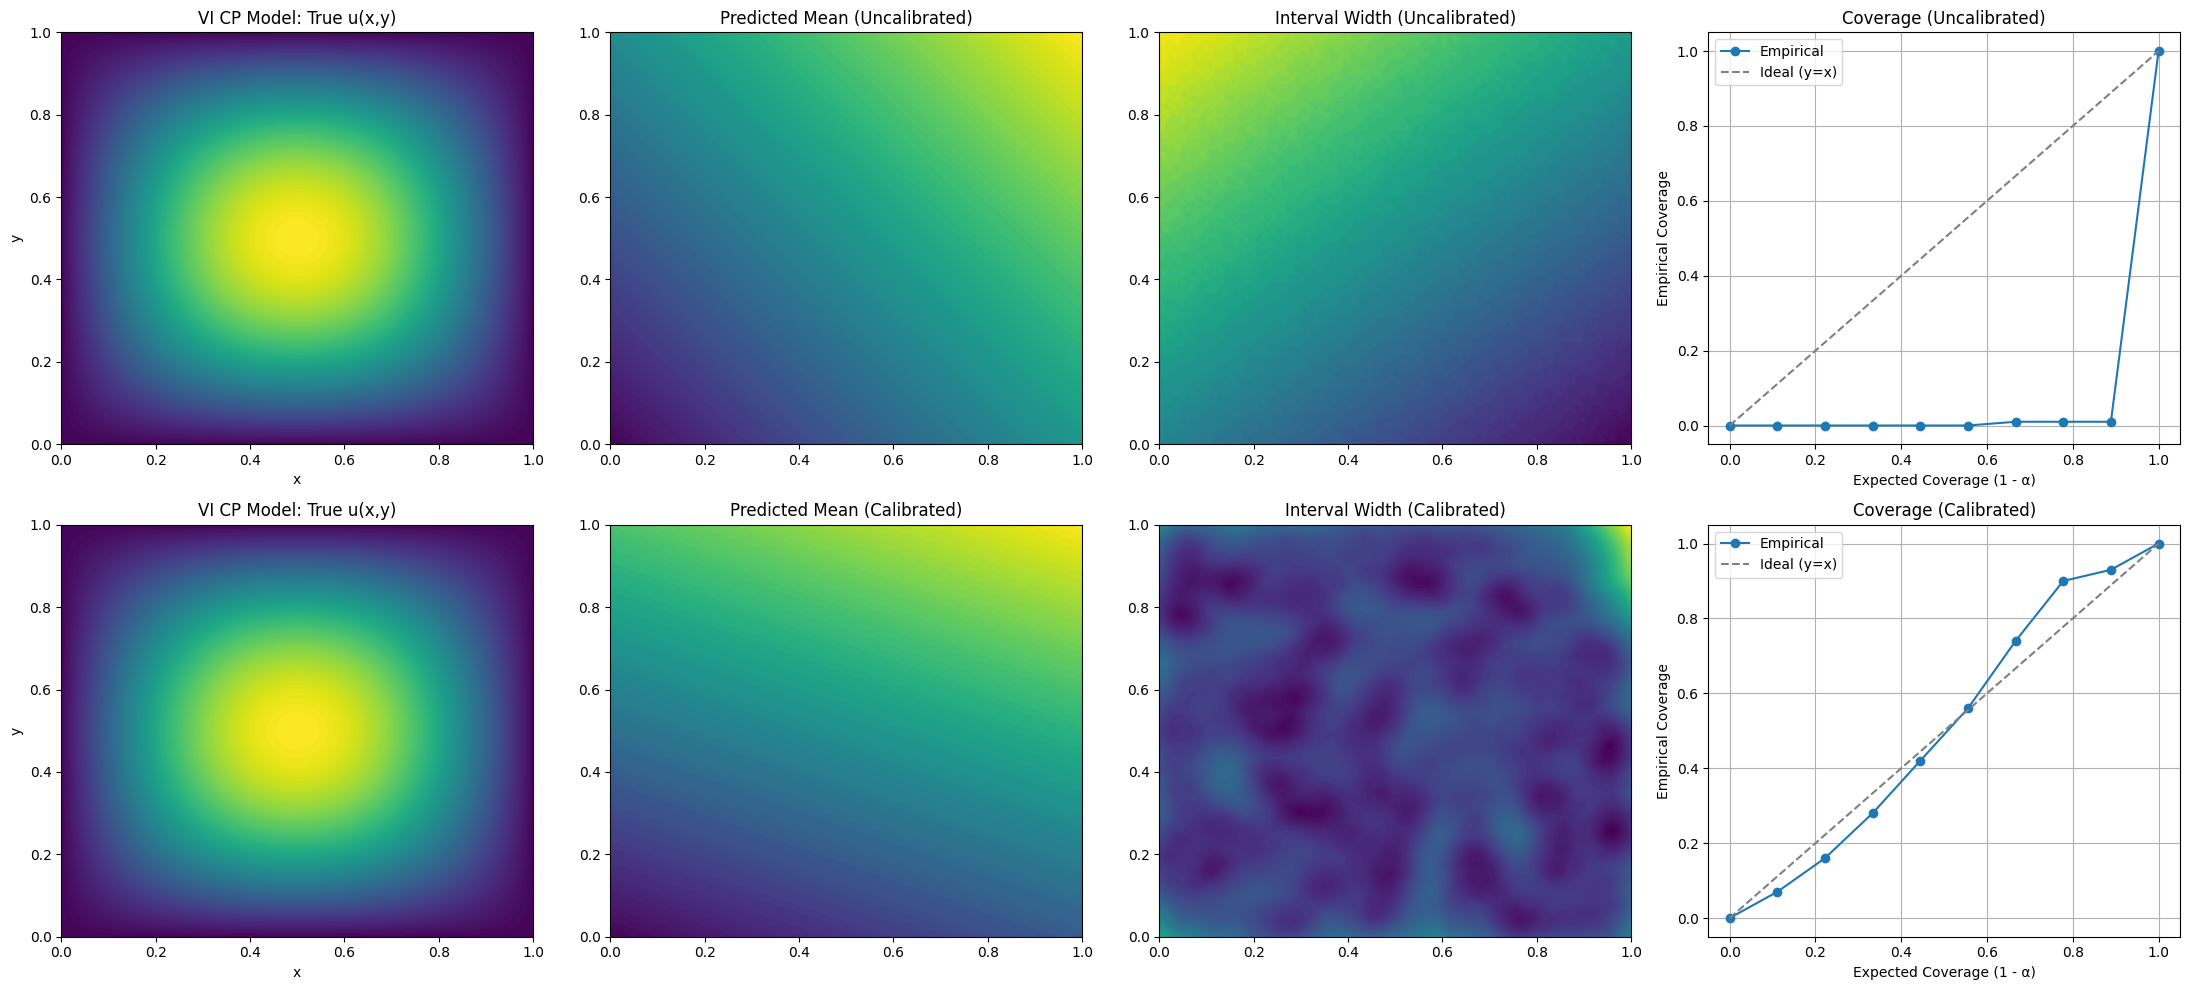

[✅] Saved plot to: vi_cp/loss_56.723; vi_cp epochs_20,λ_pde_1_0,λ_bc_1_0,λ_elbo_1_0,lr_0_001,stop_schedule_10000.png

[🔍] Trying: {'epochs': 20, 'λ_pde': 1.0, 'λ_bc': 1.0, 'λ_elbo': 1.0, 'lr': 0.001, 'stop_schedule': 20000}

[👟] Training: Baseline
ep     0 | L=6.92e+03 | elbo=1.59e+02 | pde=6.76e+03  ic=0.00e+00  bc=1.96e-03 | lr=1.00e-03 | learned noise_std=1.000e+00
ep     1 | L=1.50e+04 | elbo=1.58e+02 | pde=1.49e+04  ic=0.00e+00  bc=1.87e-03 | lr=1.00e-03 | learned noise_std=1.000e+00

[👀] Predicting: Baseline & CP

[👳🏻] Computing coverage


100%|██████████| 8/8 [01:11<00:00,  8.93s/it]


<Figure size 640x480 with 0 Axes>

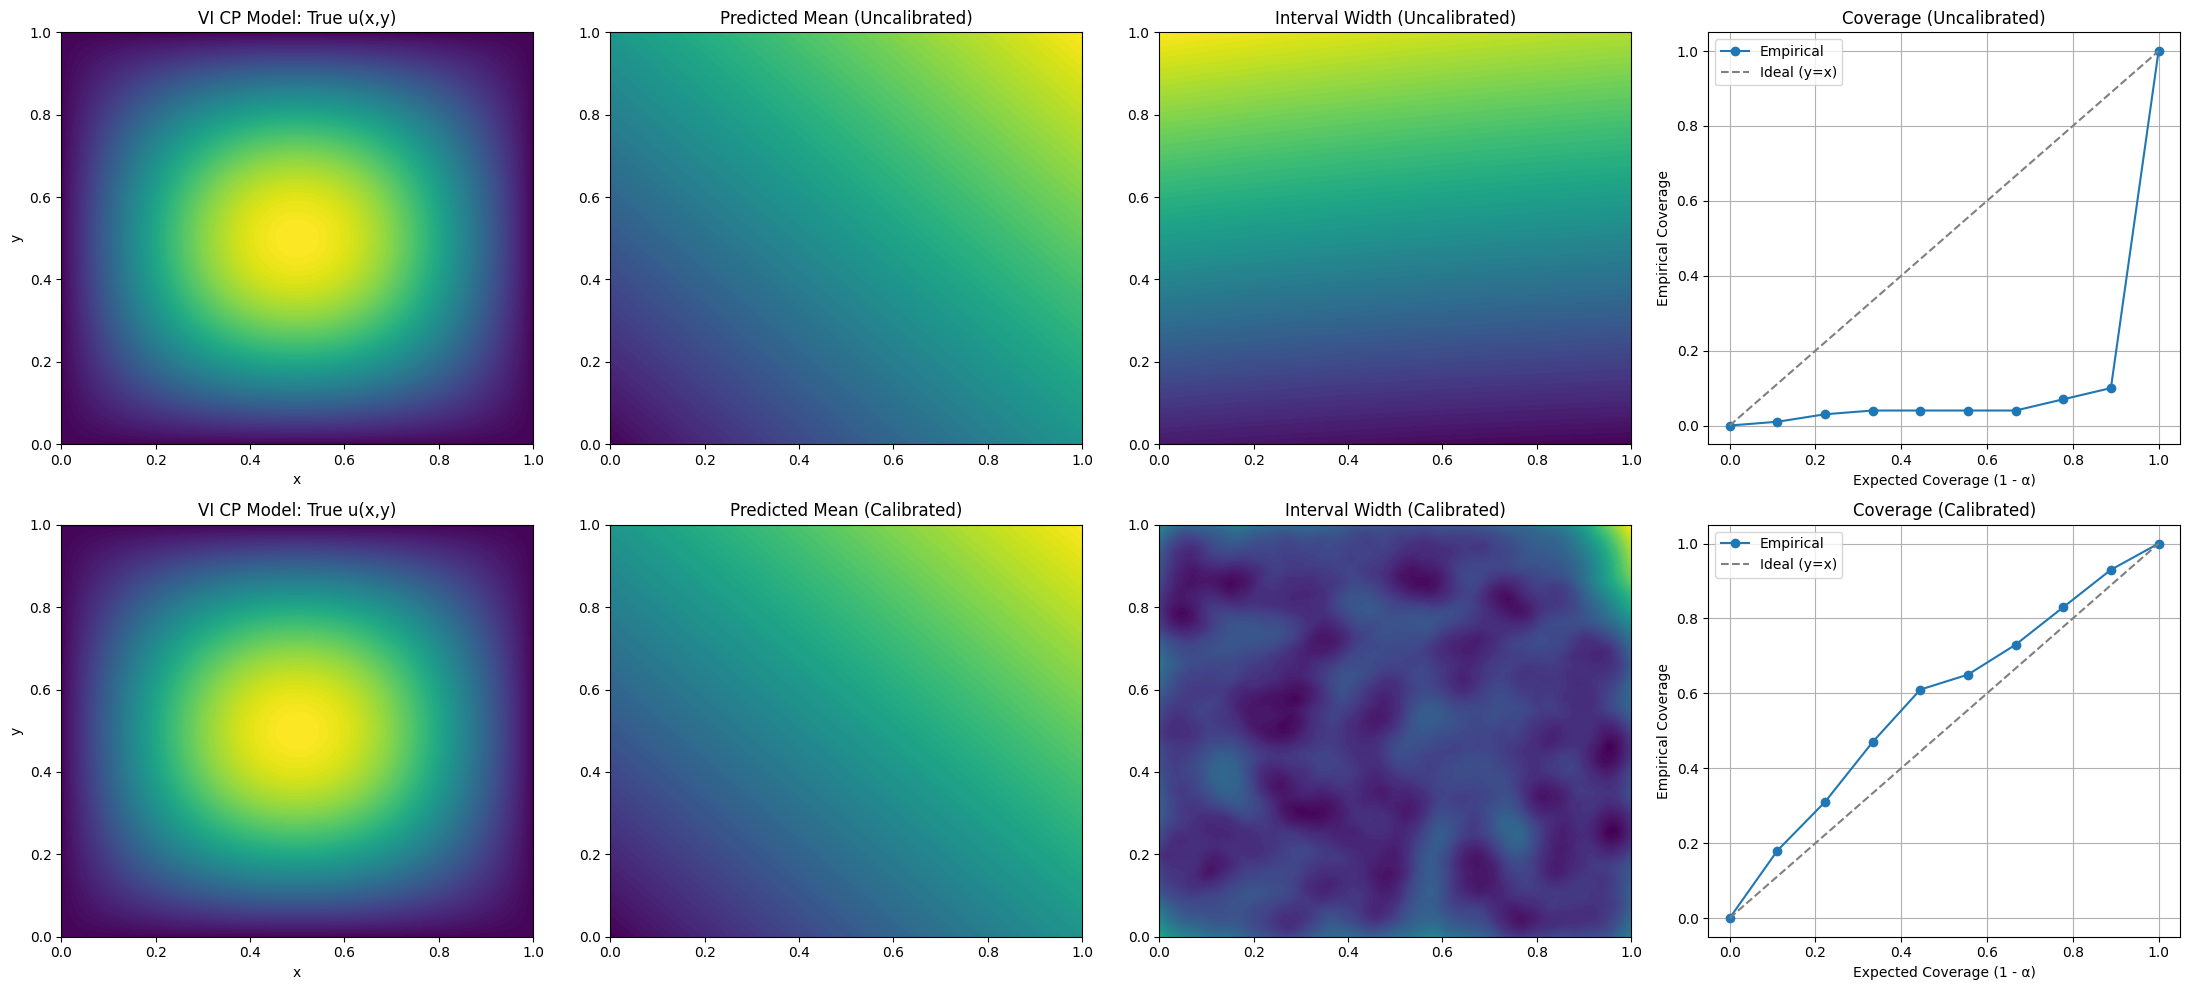

[✅] Saved plot to: vi_cp/loss_21.105; vi_cp epochs_20,λ_pde_1_0,λ_bc_1_0,λ_elbo_1_0,lr_0_001,stop_schedule_20000.png

[🔍] Trying: {'epochs': 20, 'λ_pde': 1.0, 'λ_bc': 1.0, 'λ_elbo': 1.0, 'lr': 0.001, 'stop_schedule': 40000}

[👟] Training: Baseline
ep     0 | L=6.88e+03 | elbo=1.23e+02 | pde=6.76e+03  ic=0.00e+00  bc=2.62e-01 | lr=1.00e-03 | learned noise_std=1.000e+00
ep     1 | L=1.50e+04 | elbo=1.23e+02 | pde=1.49e+04  ic=0.00e+00  bc=2.08e-01 | lr=1.00e-03 | learned noise_std=1.000e+00

[👀] Predicting: Baseline & CP

[👳🏻] Computing coverage


  0%|          | 0/8 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [1]:
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random


# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN

# CP
from utils_uqmd.utils_uq_cp import CP

# Ensure reproducibility
import random, numpy as np, torch
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



# Data Noise
data_noise = 0.05

# Define PDE
domain=((0.0, 1.0), (0.0, 1.0))
true_solution=lambda xy: torch.sin(math.pi * xy[..., 0:1]) * torch.sin(math.pi * xy[..., 1:2])
pde = Poisson2D(domain, true_solution)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(500, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)
(X_calibration, Y_calibration) = pde.data_generation(200, data_noise)

# Number of colocation point
colloc_pt_num = 100

# Generating alphas to test
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]
alphas = generating_alphas(10)



# --------------------------------------------
# Build base model
# --------------------------------------------

vi_model = VIBPINN(
    pde_class=pde, 
    input_dim=2,
    hidden_dims=[16, 32, 64, 64, 64, 32, 16], 
    output_dim=1, 
    mu_std = 0.01, rho = -5, prior_std=1.0, 
    init_data_noise=1.0, learn_data_noise=False, act_func=nn.Tanh()
)


# --------------------------------------------
# Define tuning arguments
# --------------------------------------------

# Change the parameter grids to test
fit_kwargs_grid = {
    "epochs":[20000, 30000, 40000],
    "λ_pde":[1.0, 3.0, 5.0, 10.0], "λ_bc":[1.0, 5.0, 10.0], "λ_elbo":[1.0, 2.0, 4.0],  # Change based on baseline model
    "lr":[1e-3, 3e-3],
    # "scheduler_cls":[StepLR], "scheduler_kwargs":[{'step_size': 5000, 'gamma': 0.5}],
    "stop_schedule":[10000, 20000, 40000, 100000]
}

fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}

cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",
        "k":10
}

baseline_pred_kwargs = {
    "n_samples":5000 # Change based on baseline model
}

cp_coverage_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":10
}

baseline_coverage_args = { # Change based on baseline model
    "uqmodel":vi_model, "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test
}


# --------------------------------------------
# Defining Plotting Grid
# --------------------------------------------
n_grid = 100
x = torch.linspace(0, 1, n_grid)
y = torch.linspace(0, 1, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


# --------------------------------------------
# Start hyperparameter tuning 
# --------------------------------------------
from utils_tools.utils_tuning import hyperparameter_tuning
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
from utils_uqmd.utils_uq_cp import CP
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties

hyperparameter_tuning(
    plot_title="VI CP Model",
    # Model Fitting & Predicting
    uqmodel=vi_model, alpha=0.05, 
    X_test=grid_test, Y_test=Y_test, 
    fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, baseline_pred_kwargs=baseline_pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
    true_solution=pde.true_solution,
    # Coverage Test
    baseline_coverage_args=baseline_coverage_args, cp_coverage_args=cp_coverage_args,
    baseline_test_uncertainties=vi_test_uncertainties,
    # Plotting function
    plotting_func=plot_2D_comparison_with_coverage,
    save_dir="vi_cp"
)

# Dropout Hyperparameter Tuning

In [ ]:
# TODO: Complete these dictionary. Test the hyperparameter_tuning() method
fit_args = {}
fit_kwargs_grid = {}
pred_kwargs = {}
cp_pred_kwargs = {}

hyperparameter_tuning(
        plotting_func=plot_predictions_2D_compare,
        plot_title="aewfawefawef",
        uqmodel=vi_model, alpha=0.05, 
        X_test=grid_test, Y_test=Y_test, 
        fit_args=fit_args, fit_kwargs_grid=fit_kwargs_grid, pred_kwargs=pred_kwargs, cp_pred_kwargs=cp_pred_kwargs, 
        save_dir="tuning_plots"
    )